In [1]:
import numpy as np
import os.path as osp
import uproot as ur
from glob import glob

In [2]:
filesAIDA = glob('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.*.root')
filesAIDA.sort()

filesFinalStates:list[str] =  []

for file in filesAIDA:
    dn = osp.dirname(file)
    bn = osp.basename(file)
    
    totalsuffix = bn.replace('AIDAFile_', '').replace('.root.root', '')
    p = osp.join(dn, f'FinalStates_{totalsuffix}.root')
    
    filesFinalStates.append(p)
    
print(list(zip(filesAIDA, filesFinalStates)))

[('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.eL.pR.n000.d_dstm_15740_0.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/FinalStates_e2e2qqh.eL.pR.n000.d_dstm_15740_0.root'), ('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.eL.pR.n000.d_dstm_15740_1.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/FinalStates_e2e2qqh.eL.pR.n000.d_dstm_15740_1.root'), ('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.eL.pR.n000.d_dstm_15740_2.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/FinalStates_e2e2qqh.eL.pR.n000.d_dstm_15740_2.root'), ('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.eL.pR.n000.d_dstm_15740_3.root.root', '/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/FinalStates_e2e2qqh.eL.pR.n00

In [3]:
from zhh.analysis.FlavorTagging import parse_files, get_tot_length

/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-tqdm/4.66.3-gay4aw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
length, y_true, tags_PNet, tags_LCFI, valid_jets_mask = parse_files(filesAIDA[0], filesFinalStates[0])
print(np.unique(y_true, return_counts=True))

tags_LCFI = tags_LCFI[valid_jets_mask]
tags_PNet = tags_PNet[valid_jets_mask]
y_true = y_true[valid_jets_mask]
length = len(y_true)

(array([1, 2, 3, 4, 5], dtype=int32), array([  86,   94,  124, 2329, 1567]))


In [4]:
from tqdm.auto import tqdm
from zhh.analysis.FlavorTagging import parse_files, get_tot_length

tot_length = get_tot_length(filesAIDA)
pointer_valid = 0
pointer_all = 0

tag_names = ['b', 'c', 'uds']
tagsPNet = np.zeros((tot_length, 4))
tagsLCFI = np.zeros((tot_length, len(tag_names)))
pdgs = np.zeros(tot_length, dtype='B')
valid_jets_mask = np.zeros(tot_length, dtype=bool)

for fileFinalStates, fileAIDA in (pbar := tqdm(list(zip(filesFinalStates, filesAIDA)))):
    pbar.set_description(fileAIDA)
    
    chunk_length, chunk_pdgs, chunk_tags_pnet, chunk_tags_lcfi, chunk_valid_jets_mask = parse_files(fileAIDA, fileFinalStates)
    
    pdgs[pointer_valid:pointer_valid+chunk_length] = chunk_pdgs
    tagsPNet[pointer_valid:pointer_valid+chunk_length] = chunk_tags_pnet
    tagsLCFI[pointer_valid:pointer_valid+chunk_length] = chunk_tags_lcfi
    valid_jets_mask[pointer_all:pointer_all+len(chunk_valid_jets_mask)] = chunk_valid_jets_mask
    
    pointer_valid += chunk_length
    pointer_all += len(chunk_valid_jets_mask)

pdgs = pdgs[:pointer_valid]
tagsPNet = tagsPNet[:pointer_valid]
tagsLCFI = tagsLCFI[:pointer_valid]
valid_jets_mask = valid_jets_mask[:pointer_all]

# convert PDGs to labels
y_true = np.zeros(len(pdgs), dtype='B')
for needle, replace in [
    (1, 2),
    (2, 2),
    (3, 2),
    (4, 1),
    (5, 0)
]:
    y_true[pdgs == needle] = replace

/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.eR.pL.n001.d_dstm_15740_9.root.root: 100%|██████████| 38/38 [00:03<00:00, 12.00it/s] 


In [5]:
print(tot_length, len(valid_jets_mask))

176896 176896


In [6]:
np.unique(y_true, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([75253, 89103, 12540]))

In [31]:
np.savez('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/other/FTag/4_testing_zzh/preds_marlin_zzh.npz',
         y_true=y_true,
         tagsPNet=tagsPNet,
         tagsLCFI=tagsLCFI,
         valid_jets_mask=valid_jets_mask)

0 1
0 invalid
943 invalid
1 0
0 invalid
943 invalid
0 2
0 invalid
602 invalid


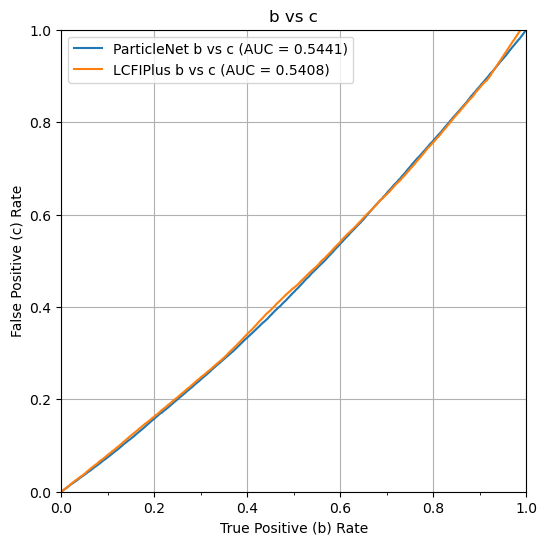

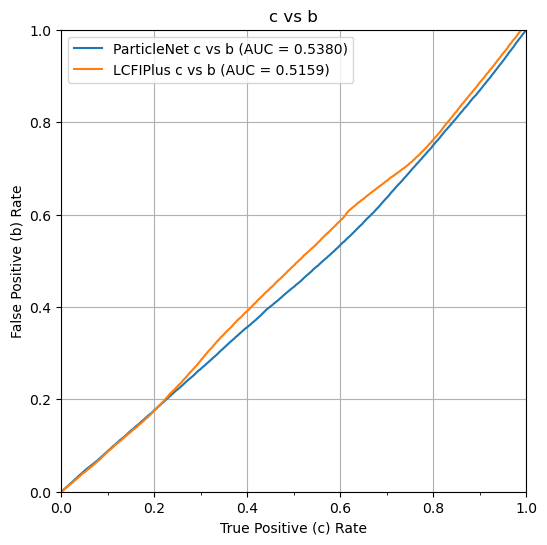

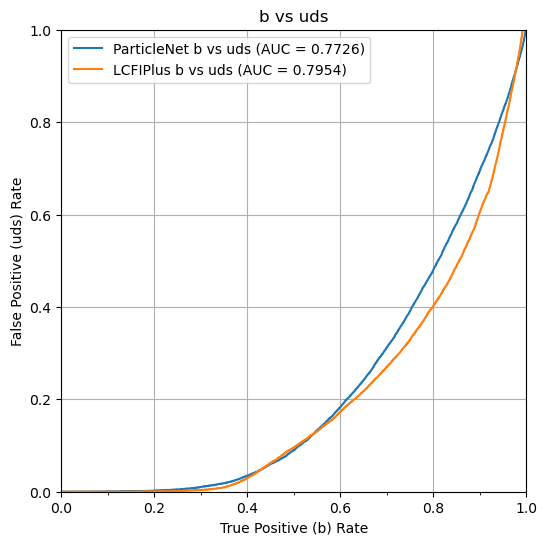

In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

rocs = {}
for sig_name, bkg_name in [
    ('b', 'c'),
    ('c', 'b'),
    ('b', 'uds')
]:
    sig_index, bkg_index = tag_names.index(sig_name), tag_names.index(bkg_name)
    mask = (y_true == sig_index) | (y_true == bkg_index)
    print(sig_index, bkg_index)

    fig, ax = plt.subplots(figsize=(6, 6))

    for tags, label in [
        (tagsPNet, 'ParticleNet'),
        (tagsLCFI, 'LCFIPlus')
    ]:        
        y_true_subset = np.copy(y_true[mask])
        pred_sig = tags[mask, sig_index]
        
        mask_sig = y_true_subset == sig_index
        mask_bkg = y_true_subset == bkg_index
        y_true_subset[mask_sig] = 1
        y_true_subset[mask_bkg] = 0
        
        # invalid predictions: assume signal, but predicted as background
        mask_invalid = tags[mask].sum(axis=1) == 0
        print(f'{(mask_invalid).sum()} invalid')
        
        y_true_subset[mask_invalid] = 1
        pred_sig[mask_invalid] = 0
        
        # calculate roc curve and plot
        fpr, tpr, threshold = metrics.roc_curve(y_true_subset, pred_sig)
        roc_auc = metrics.auc(fpr, tpr)

        rocs[f'{label}_{sig_name}_vs_{bkg_name}'] = roc_auc
        
        ax.plot(tpr, fpr, label=f'{label} {sig_name} vs {bkg_name} (AUC = {roc_auc:.4f})');
        ax.xaxis.set_minor_locator(ticker.FixedLocator(.1 + np.arange(5)*.2))

    ax.set_xlabel(f'True Positive ({sig_name}) Rate')
    ax.set_ylabel(f'False Positive ({bkg_name}) Rate')
    if True:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    else:
        ax.set_yscale('log')
    ax.set_title(f'{sig_name} vs {bkg_name}')
    ax.grid()
    ax.legend()

In [11]:
tagsPNet.shape

(163488, 4)

In [ ]:
(tags_LCFI.sum(axis=1) == 0).sum()

27

In [12]:
ff = ur.open(filesFinalStates[0])

In [30]:
pdgs = np.array(ff['FinalStates']['final_state_counts.first'].array(entry_stop=1))[0]
pdgs

array([ 1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25],
      dtype=int32)

In [37]:
np.where(pdgs == 2)[0]

array([1])

In [16]:
ff['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs',
 'passed']

In [6]:
length

4200

In [9]:
fs_counts[fs_passed_mask]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [10]:
truth_label = np.abs(np.array(af['Jets']['TrueJetInitialElementonPDG'].array()))
truth_label

array([5, 5, 4, ..., 4, 4, 4], dtype=int32)

In [11]:
np.unique(truth_label, return_counts=True)

(array([ 1,  2,  3,  4,  5, 99], dtype=int32),
 array([  86,   94,  124, 2329, 1567,  400]))

In [29]:
af['JetTaggingComparison']['tags1'].array()

<Array [[0.998, 0.00139, ..., 0.000102], ..., [...]] type='4 * var * float32'>

In [30]:
af['JetTaggingComparison']['tags2'].array()

<Array [[0.999, 0.000418, 0.000153], ..., [...]] type='4 * var * float32'>

In [6]:
def get_tot_length(paths:list[str])->int:
    result = 0
    for path in paths:
        with ur.open(path) as rf:
            result += len(rf['JetTaggingComparison']['event'].array())
    
    return result

def parse_file(path:str):    
    with ur.open(path) as uf:
        comparison = uf['JetTaggingComparison']
        
        event_nr = np.array(comparison['event'].array(), dtype=int)
        
        tot_length = len(event_nr)

        # get the tags
        tagsPNet_raw = np.array(comparison['tags1'].array()).squeeze()

        tagsLCFI = np.array(comparison['tags2'].array()).squeeze()
        tagsPNet = np.zeros(tagsLCFI.shape)
        tagsPNet[:, [0,1,2]] = tagsPNet_raw[:, [0,1,2]]
        tagsPNet[:, 2] += tagsPNet_raw[:, 3]

        print('pre check', len(tagsPNet), tagsPNet.sum(), tagsLCFI.sum())
        
        tot_length = len(tagsPNet)
        y_true = np.zeros(tot_length)
    
        return tot_length, y_true, tagsLCFI

# TODO: # sort out invalid predictions
# some rows in LCFIPlus are zero; TODO: Why?
#        mask_invalid = tagsLCFI.sum(axis=1) == 0

In [7]:
for file in files:
    tot_length, tagsPNet, tagsLCFI = parse_file(file)

pre check 4 3.999999834195478 4.0


In [8]:
rf = ur.open(file)

In [14]:
rf['Jets'].keys()

['JetEnergy',
 'JetPt',
 'JetMomentum',
 'JetTheta',
 'JetPhi',
 'JetRapidity',
 'NCharged',
 'NNeutral',
 'NSecondaryVertices',
 'NPseudoVertices',
 'D0bprob',
 'D0cprob',
 'D0qprob',
 'Z0bprob',
 'Z0cprob',
 'Z0qprob',
 'TrkMass',
 'JetIndex',
 'Event',
 'Run',
 'TrueJetInitialElementonPDG',
 'TrueJetFinalElementonPDG',
 'TrueJetType']

In [15]:
np.array(rf['Jets']['TrueJetType'].array())

array([301,   1,   1,   1], dtype=int32)

In [17]:
np.array(rf['Jets']['TrueJetFinalElementonPDG'].array())

array([ 1, -5,  4,  4], dtype=int32)